In [1]:
#!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [3]:
"""
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image{}'.format(imgnum))
    ret,frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
"""

"\ncap = cv2.VideoCapture(0)\nfor imgnum in range(number_images):\n    print('Collecting image{}'.format(imgnum))\n    ret,frame = cap.read()\n    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')\n    cv2.imwrite(imgname, frame)\n    cv2.imshow('frame',frame)\n    time.sleep(0.5)\n\n    if cv2.waitKey(1) & 0xFF == ord('q'):\n        break\ncap.release()\ncv2.destroyAllWindows()\n"

In [4]:
#!labelme

In [5]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [6]:
# To Avoid OOM errors on exagerated GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [25]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=True)

In [26]:
#Checking that work as should
#images.as_numpy_iterator().next()

In [27]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [28]:
images = images.map(load_image)

In [29]:
#Checking that work as should
#images.as_numpy_iterator().next()

In [34]:
image_generator = images.batch(4).as_numpy_iterator()

In [35]:
plot_images = image_generator.next()

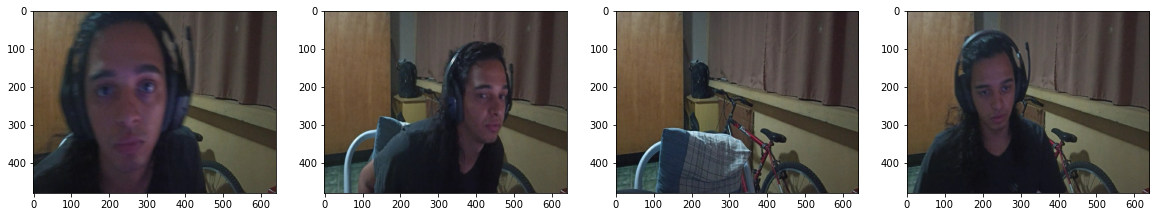

In [36]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [37]:
117*.7 #81 to train 

81.89999999999999

In [38]:
117*.15 #18 to test and val

17.55

In [40]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)

In [42]:
import albumentations as alb

In [43]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [44]:
img = cv2.imread(os.path.join('data','train', 'images','4844fcd7-3866-11ed-b587-a85e451e9a26.jpg'))

In [45]:
with open(os.path.join('data', 'train', 'labels', '4844fcd7-3866-11ed-b587-a85e451e9a26.json'), 'r') as f:
    label = json.load(f)

In [46]:
label['shapes'][0]

{'label': 'face',
 'points': [[174.5148514851485, 4.9405940594059405],
  [345.3069306930693, 278.7029702970297]],
 'group_id': None,
 'shape_type': 'rectangle',
 'flags': {}}

In [47]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [48]:
coords

[174.5148514851485, 4.9405940594059405, 345.3069306930693, 278.7029702970297]

In [49]:
coords = list(np.divide(coords, [640,480,640,480]))

In [50]:
coords

[0.27267945544554456,
 0.010292904290429042,
 0.5395420792079209,
 0.5806311881188119]

In [51]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

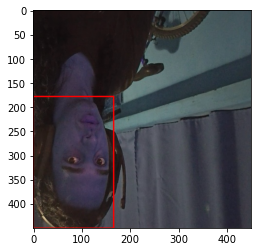

In [53]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [54]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [63]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [66]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [67]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [68]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [69]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [70]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [71]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [72]:
#len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4860, 4860, 1080, 1080, 1080, 1080)

In [73]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [74]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [76]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1200)
val = val.batch(8)
val = val.prefetch(4)

In [79]:
#train.as_numpy_iterator().next()[0]

In [80]:
data_samples = train.as_numpy_iterator()

In [101]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


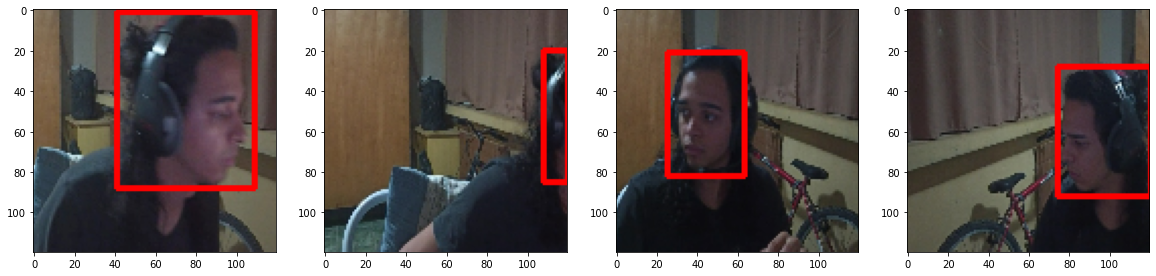

In [102]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [103]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [104]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 35s 1us/step


In [105]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [106]:
facetracker = build_model()

In [107]:
X, y = train.as_numpy_iterator().next()

In [108]:
X.shape

(8, 120, 120, 3)

In [109]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 7s 7s/step


In [110]:
classes, coords

(array([[0.413116  ],
        [0.46904483],
        [0.42663044],
        [0.41841018],
        [0.4709855 ],
        [0.41612467],
        [0.5250796 ],
        [0.45281217]], dtype=float32),
 array([[0.40977556, 0.528711  , 0.6223007 , 0.61000437],
        [0.3676687 , 0.6021875 , 0.5000989 , 0.65347904],
        [0.3745932 , 0.63193554, 0.59299284, 0.6507176 ],
        [0.467805  , 0.580045  , 0.61499804, 0.6256488 ],
        [0.40658712, 0.5910687 , 0.5926575 , 0.61656195],
        [0.3984267 , 0.54502124, 0.582196  , 0.6596204 ],
        [0.44957647, 0.6096325 , 0.6105031 , 0.66838896],
        [0.42008817, 0.62245244, 0.62684005, 0.6219776 ]], dtype=float32))

In [112]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [113]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [114]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [115]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [116]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.7170825>

In [117]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.77246225>

In [118]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.7170825>

In [119]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [120]:
model = FaceTracker(facetracker)

In [121]:
model.compile(opt, classloss, regressloss)

In [123]:
logdir='logs'

In [124]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [125]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
608/608 [==============================] - 53s 74ms/step - total_loss: 0.3971 - class_loss: 0.0749 - regress_loss: 0.3597 - val_total_loss: 0.1873 - val_class_loss: 0.0482 - val_regress_loss: 0.1632
Epoch 2/10
608/608 [==============================] - 48s 72ms/step - total_loss: 0.1317 - class_loss: 0.0308 - regress_loss: 0.1163 - val_total_loss: 0.0648 - val_class_loss: 0.0062 - val_regress_loss: 0.0617
Epoch 3/10
608/608 [==============================] - 48s 72ms/step - total_loss: 0.0766 - class_loss: 0.0185 - regress_loss: 0.0673 - val_total_loss: 0.0423 - val_class_loss: 0.0073 - val_regress_loss: 0.0387
Epoch 4/10
608/608 [==============================] - 48s 72ms/step - total_loss: 0.0610 - class_loss: 0.0134 - regress_loss: 0.0543 - val_total_loss: 0.0449 - val_class_loss: 4.0266e-04 - val_regress_loss: 0.0447
Epoch 5/10
608/608 [==============================] - 48s 72ms/step - total_loss: 0.0578 - class_loss: 0.0142 - regress_loss: 0.0507 - val_total_loss: 0.247

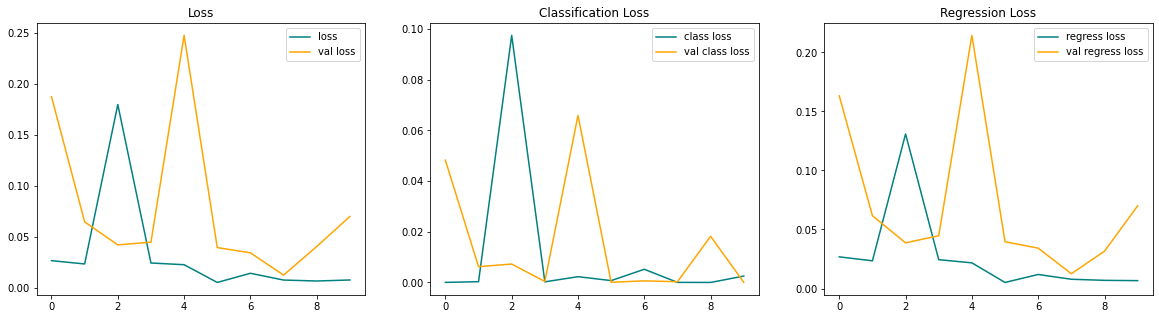

In [126]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [127]:
test_data = test.as_numpy_iterator()

In [190]:
test_sample = test_data.next()

In [191]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


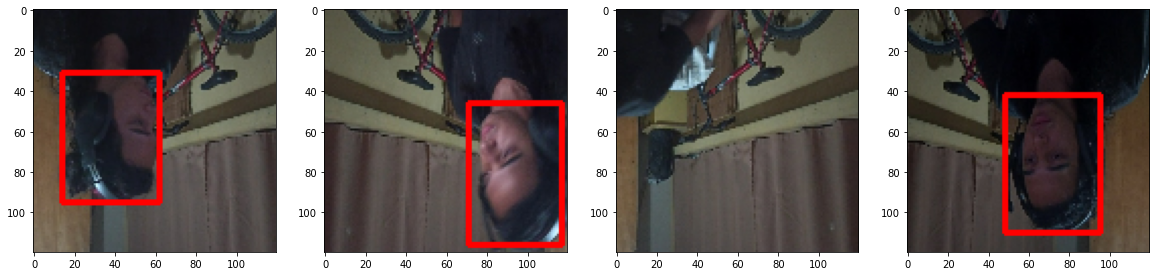

In [192]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [193]:
from tensorflow.keras.models import load_model

In [201]:
facetracker.save('facetracker.h5')

In [202]:
facetracker = load_model('facetracker.h5')

In [209]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (220,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (220,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Cara', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)
    
    cv2.imshow('MauMauTracker', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step
